+++
notebook = true
title = "Reading OGS Output: Diffusion, Sorption, and Decay in a 1D Reactive Transport Model"
date = "2025-08-13"
author = "Philipp Selzer, Jörg Buchwald, Devansh Shukla"
+++


<div class="note">
    <p style="margin-top: 0; margin-bottom: 0;">
        <img style="margin-top: 0; margin-bottom: 0; height: 2em;" class="inline-block mr-2 no-fancybox"
            src="https://upload.wikimedia.org/wikipedia/commons/3/38/Jupyter_logo.svg" alt="">
        This page is based on a Jupyter notebook.
<a href="./transport_tutorial.ipynb" download="transport_tutorial.ipynb"><img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" src="https://img.shields.io/static/v1?label=Download:&message=transport_tutorial.ipynb&color=blue" /></a>
<a href="https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/../../web/content/docs/tutorials/transport_tutorial/notebook-transport_tutorial.py"><img src="https://img.shields.io/static/v1?label=Source:&message=notebook-transport_tutorial.py&color=brightgreen" class="no-fancybox"
        style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" /></a>
<a href="https://binder.opengeosys.org/v2/gh/bilke/binder-ogs-requirements/6.5.6-0.7.0?urlpath=git-pull%3Frepo=https://gitlab.opengeosys.org/ogs/ogs%26urlpath=lab/tree/ogs/Tests/Data/../../web/content/docs/tutorials/transport_tutorial/notebook-transport_tutorial.py%26branch=6.5.6%26depth=1">
    <img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;"
        src="https://img.shields.io/static/v1?label=&message=Launch notebook&color=5c5c5c&logo=" />
</a></p></div>

## Goals

In this tutorial, you will learn how to set up and run a 1D reactive transport model of Iodide-129 in OGS, read and visualize simulation output, and modify key parameters using Python.

## Model Preparation

For this example, we consider a one-dimensional model domain $\Omega \subset \mathbb{R}^1$ (see figure below) with coordinates in the range $x \in [0, 1009]$ m.

- Lower boundary: $x = 0\,\mathrm{m}$ – coincides with the bedrock interface.
- Upper boundary: $x = 1009\,\mathrm{m}$ – represents the ground surface.

A hypothetical repository is located at $x = 420\,\mathrm{m}$ above the bedrock. Here, we only model Iodide-129 and all other radionuclides are ignored.

The initial condition is a $1\,\mathrm{m}$ long concentration peak centered at the repository, with node values chosen so that the total concentration at $t=0\,\mathrm{s}$ integrates to $2\,\mathrm{mol/L}$ .

The model solves the transport equation with diffusion, sorption, and (simplified) radioactive decay. Concentrations are expressed in $\mathrm{mol/L}$.

We use the following boundary conditions for the I-129 model:

- Lower boundary condition: No-flow for concentration.
- Upper boundary condition: Dirichlet, fixed at $c = 0\,\mathrm{mol/L}$.

Note that in this example, the porosity is taken to be the accessible porosity for I-129. In OGS, only a single porosity value is defined, corresponding to the flow-effective porosity.

The figure below shows the simplified stratigraphic profile representing the example geology:
![Domain](figures/stratigraphic_profile_420m_new_Paper.png)

## Getting started

First, install python:

- Linux: Python is usually preinstalled.
- Windows / Mac OS: Download and install the latest Python release, eg. from the official website.

We recommend working in a virtual environment to keep dependencies isolated.
Instructions for setting one up — along with an introduction to OpenGeoSys (OGS) — are available in the [OGS user guide](https://www.opengeosys.org/docs/userguide/basics/introduction/).

You can install the OGS executable directly via pip as described in the above guide, or build OGS from source with your preferred configuration: [opengeosys.org/docs/devguide/getting-started/prerequisites](https://www.opengeosys.org/docs/devguide/getting-started/prerequisites/).

In addition to OGS this notebooks requires some additional Python packages. Apart from the rather standard ones (Matplotlib, NumPy) this is OGSTools. All requirements should be fulfilled if you install

```sh
pip install ogstools[ogs]
```

Once Python and OpenGeoSys are set up, we can start our tutorial.

The next step is to import the required Python libraries for running the simulation and plotting the results.

In [1]:
import os

# Suppress tqdm progress bars
os.environ["TQDM_DISABLE"] = "1"

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import ogstools as ot
from ogstools.meshlib import MeshSeries

Next, we define the paths and specify the OGS project file, which is an XML file that contains the complete simulation setup, including geometry, material properties, processes, and boundary and initial conditions.
For more details, see the [OGS project file documentation](https://www.opengeosys.org/docs/userguide/basics/project_file_intro/).


In [2]:
project_dir = Path()
out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", project_dir / "_out"))
if not out_dir.exists():
    out_dir.mkdir(parents=True)

project_file = project_dir / "Iodide129_main.prj"

## How to run OpenGeoSys

You can run an OpenGeoSys (OGS) simulation in two ways:

1. **Using Python**
2. **Using the OGS command-line binaries**

For an overview, see the guide: [Your first OGS run in 5 minutes](https://www.opengeosys.org/docs/userguide/basics/5-mins-ogs/).

In this tutorial, we will use Python (option 1)


In [3]:
model = ot.Project(
    input_file=project_file,
    output_file=project_file,
)

In [4]:
model.run_model(logfile=out_dir / "out.txt", args=f"-o {out_dir}")

Project file written to output.
Simulation: Iodide129_main.prj
Status: finished successfully.
Execution took 2.796635150909424 s


Now that the simulation has finished, let's take a look at the results.

Before we start plotting though, we will define the key output variables in the OGSTools context. Doing so makes it easier to call OGSTools built-in high-level plotting and analysis functions in the next steps.

In [5]:
I129 = ot.variables.Scalar(
    data_name="[I-129]",
    data_unit="mol/L",
    output_unit="mol/L",
    output_name="I-129",
)
I129Flux = ot.variables.Vector(
    data_name="[I-129]Flux",
    data_unit="mol m/L/s",
    output_unit="mol m/L/s",
    output_name="I-129 Flux",
    symbol="\\Phi",
)

## Reading an individual .vtu file: Getting a profile in space

A `.VTU` file is a VTK Unstructured Grid containing simulation results (e.g., concentrations, fluxes) for a single time step.

We will use these files to visualize results and generate a spatial profile.

In [6]:
# Here `Iodide129_GIA_ts_1021_t_31557600000000.000000.vtu` corresponds to the output file at 1e6 years
ms = MeshSeries(out_dir / "Iodide129_GIA_ts_1021_t_31557600000000.000000.vtu")

You can get more details about the `MeshSeries` by printing its metadata:

In [7]:
ms.mesh(0)

Mesh (0x7fd955d84820)
  N Cells:    3811
  N Points:   3812
  X Bounds:   0.000e+00, 0.000e+00
  Y Bounds:   0.000e+00, 0.000e+00
  Z Bounds:   0.000e+00, 1.009e+03
  N Arrays:   4

As shown in the metadata above, this 1D model is configured as if it were three-dimensional. However, it has an extension only in $z$ direction.

The metadata lists three field-data quantities:

- `[I-129]` - concentration of the Iodide-129 radioisotope, $[\mathrm{mol/L}]$
- `[I-129]Flux` - flux of Iodide-129, in $[(\mathrm{mol/L}) * (\mathrm{m/s})]$
- `pressure` - pressure profile, in $[\mathrm{Pa}]$, or hydraulic head, in $[\mathrm{m}]$

Next, we will visualize each of these field-data quantities in space for a fixed time $t$

### Spatial profile of Iodide-129 and Iodide-129 flux ($\Phi_z$)

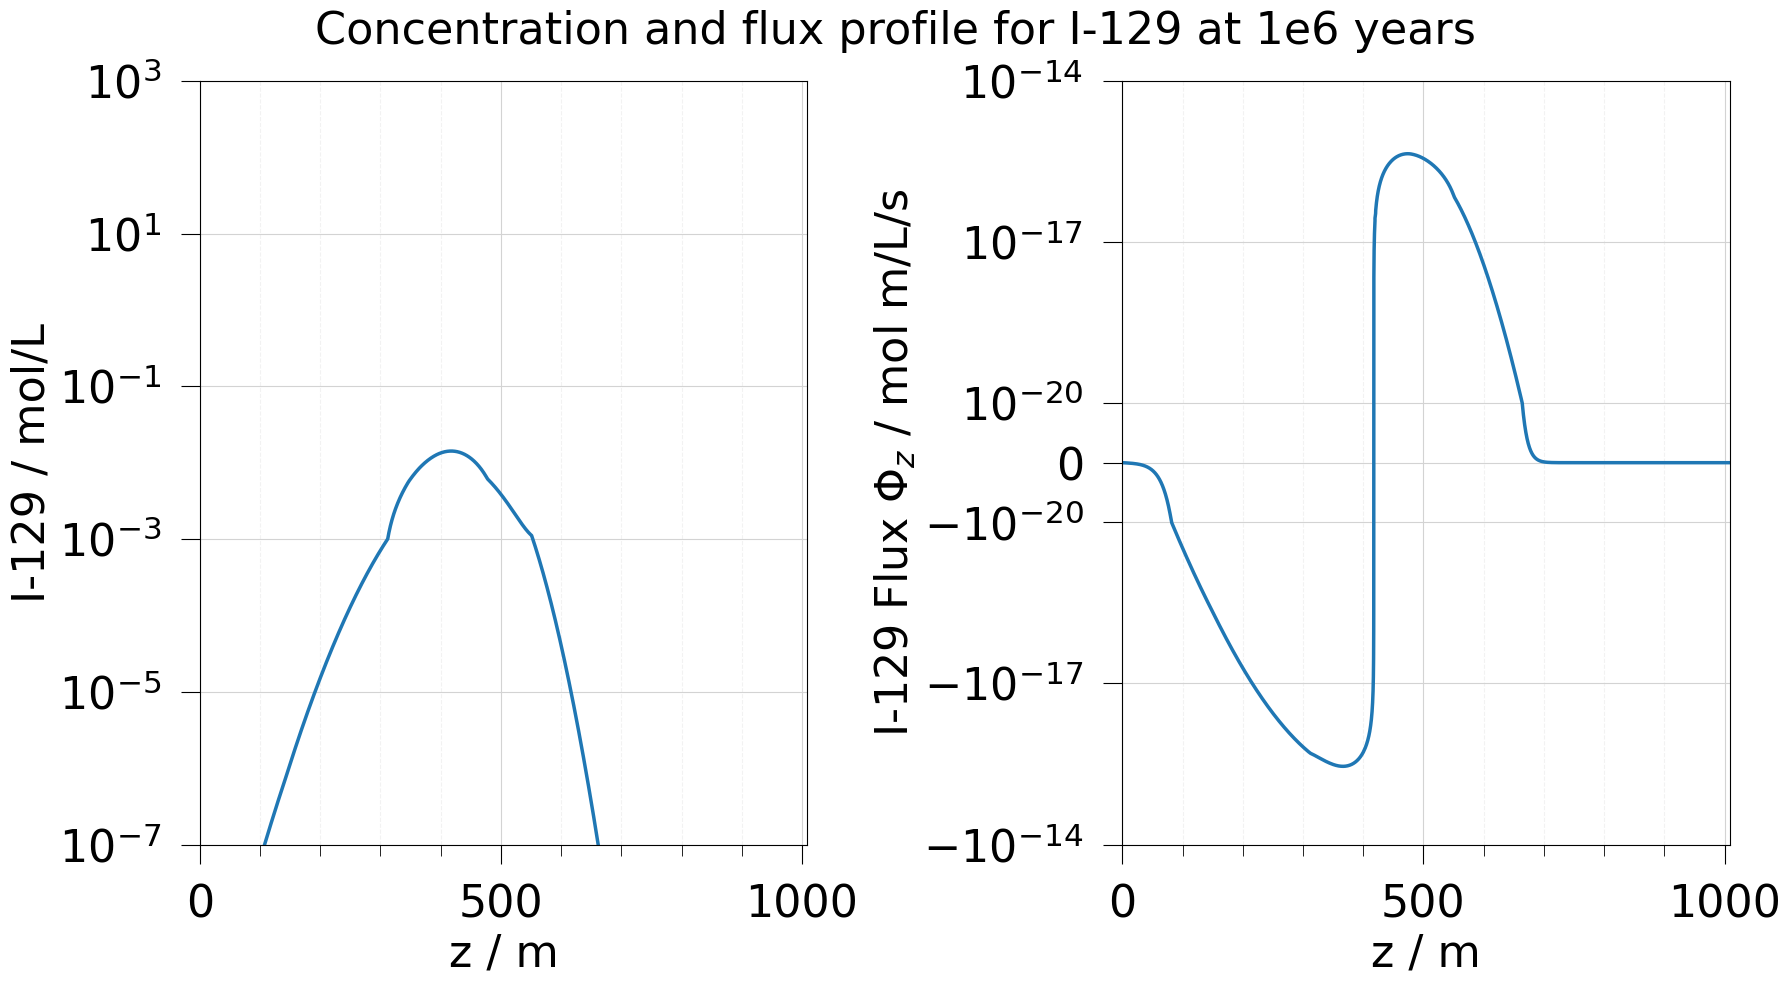

In [8]:
z_points = ms.mesh(0).points[:, 2]

fig, ax = plt.subplots(ncols=2, figsize=(18, 10))

ot.plot.line(ms, "z", I129, ax=ax[0])
ax[0].set_xlim(z_points.min(), z_points.max())
ax[0].set_yscale("log")
ax[0].set_ylim(1e-7, 1e3)

ot.plot.line(ms, "z", I129Flux["z"], ax=ax[1])
ax[1].set_ylim(-1e-14, 1e-14)
ax[1].set_yscale(
    "symlog", linthresh=10**-20
)  # By this, the y-axis is logarithmitic outside of [-1e-20,1e-20], and linear otherwise, however, some artifacts of double-plotting are there
ax[1].set_xlim(z_points.min(), z_points.max())
fig.suptitle("Concentration and flux profile for I-129 at 1e6 years", fontsize=32)

# Fix fontsizes
ot.plot.utils.update_font_sizes(ax)
fig.tight_layout()

## Reading a set of .vtu files: Getting a profile in time

The `.PVD` file, which references all corresponding `.VTU` files, contains time values ranging from $0$ years to just under $10^6$ years.

In [9]:
ms_pvd = MeshSeries(out_dir / "Iodide129_GIA.pvd").scale(time=("s", "yrs"))

As stated earlier, our repository is located at a depth of $420 \mathrm{m}$.

In this section, we will probe the Iodide-129 concentration at two nearby points using the `ogstools` method `MeshSeries.extract_probe`.
Let the points be: $p_0 = (0, 0, 419.4\,\mathrm{m})$ and $p_1 = (0, 0, 420.7\,\mathrm{m})$

In [10]:
points = np.array([(0.0, 0.0, 419.4), (0.0, 0.0, 420.7)])
labels = [rf"$p_{i}$, $z = {pt[2]}\,$m" for i, pt in enumerate(points)]

ms_pts = [ot.MeshSeries.extract_probe(ms_pvd, pts, I129) for pts in points]

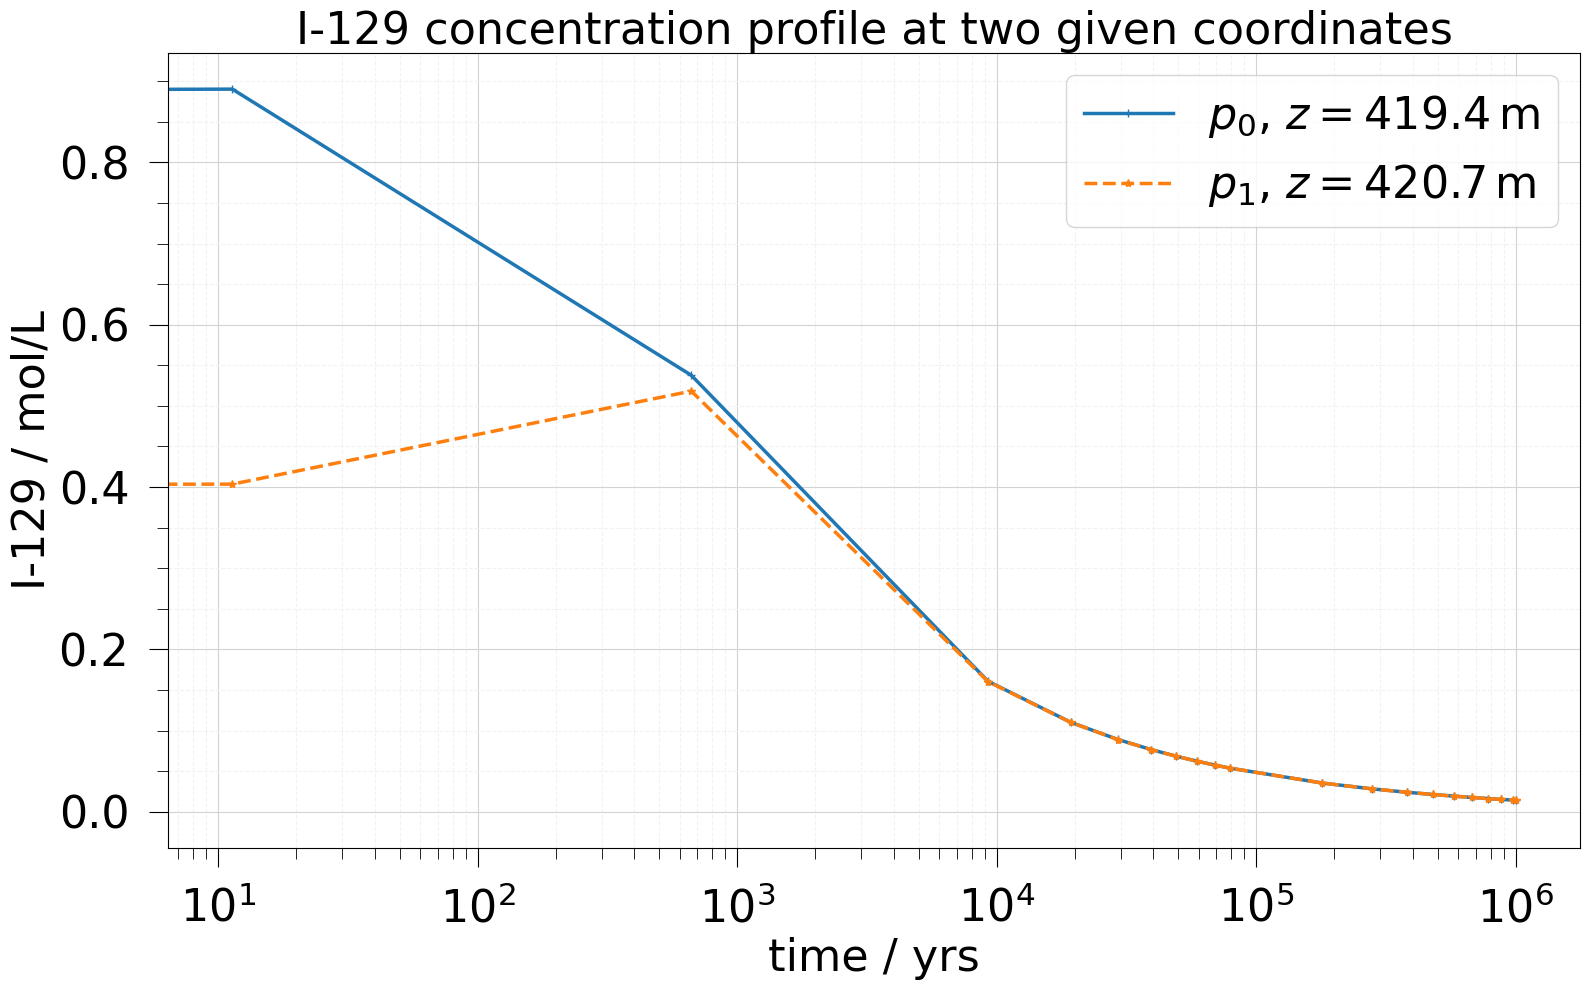

In [11]:
fig, ax = plt.subplots(figsize=(16, 10))

ot.plot.line(ms_pts[0], "time", I129, ax, label=labels[0], color="C0", marker="+")
ot.plot.line(
    ms_pts[1], "time", I129, ax, label=labels[1], color="C1", marker="*", linestyle="--"
)
ax.set_xscale("log")
ax.set_title("I-129 concentration profile at two given coordinates")

# Fix fontsizes
ot.plot.utils.update_font_sizes(ax)
fig.tight_layout()

The `.PVD` file contains 21 time steps ranging from $0$ to $10^6$ years. We will now plot the profile at multiple time steps.

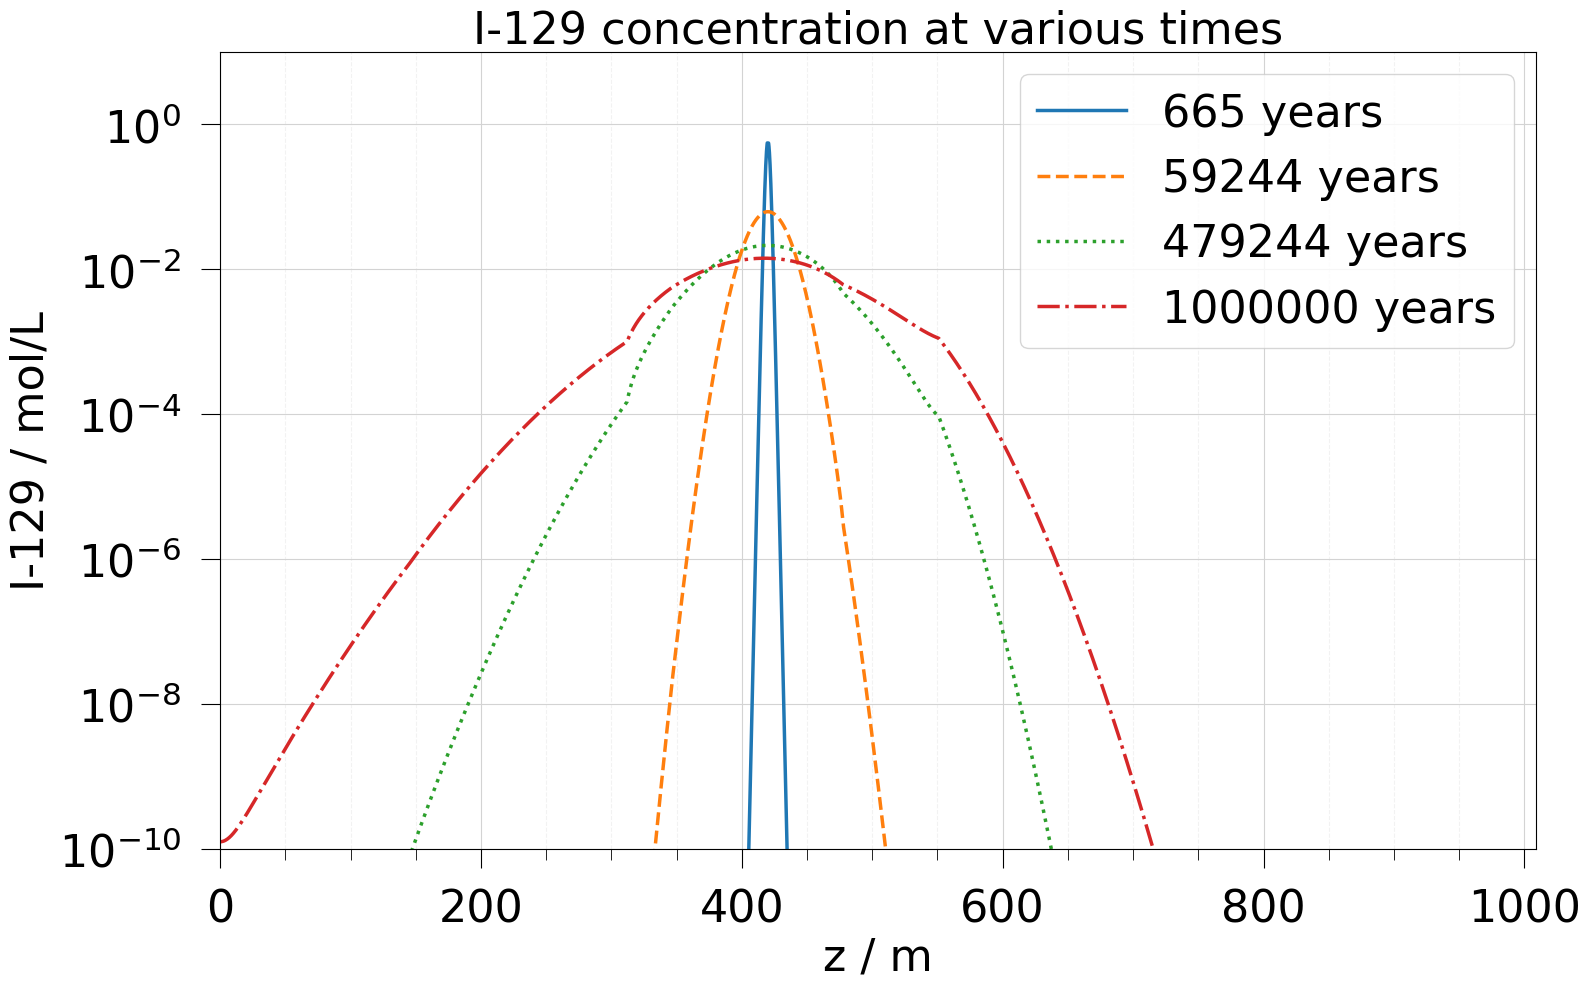

In [12]:
style_cycler = ot.plot.utils.get_style_cycler(min_number_of_styles=4)

timevalues = ms_pvd.timevalues
timesteps_to_probe = ms_pvd.timesteps[2::6]

meshes = [ms_pvd.mesh(ts) for ts in timesteps_to_probe]
labels = [f"{np.round(timevalues[ts], 0):.0f} years" for ts in timesteps_to_probe]

fig, ax = plt.subplots(ncols=1, figsize=(16, 10))
for mesh, label, style in zip(meshes, labels, style_cycler, strict=True):
    ot.plot.line(
        mesh,
        "z",
        I129,
        label=label,
        ax=ax,
        color=style["color"],
        linestyle=style["linestyle"],
    )

ax.set_xlim(z_points.min(), z_points.max())
ax.set_yscale("log")
ax.set_ylim(1e-10, 1e1)
ax.set_title("I-129 concentration at various times")

# Fix fontsizes
ot.plot.utils.update_font_sizes(ax)
fig.tight_layout()

Similarly, we can create a plot illustrating the I-129 flux ($\Phi_z$) over multiple time steps till $10^6$ years.

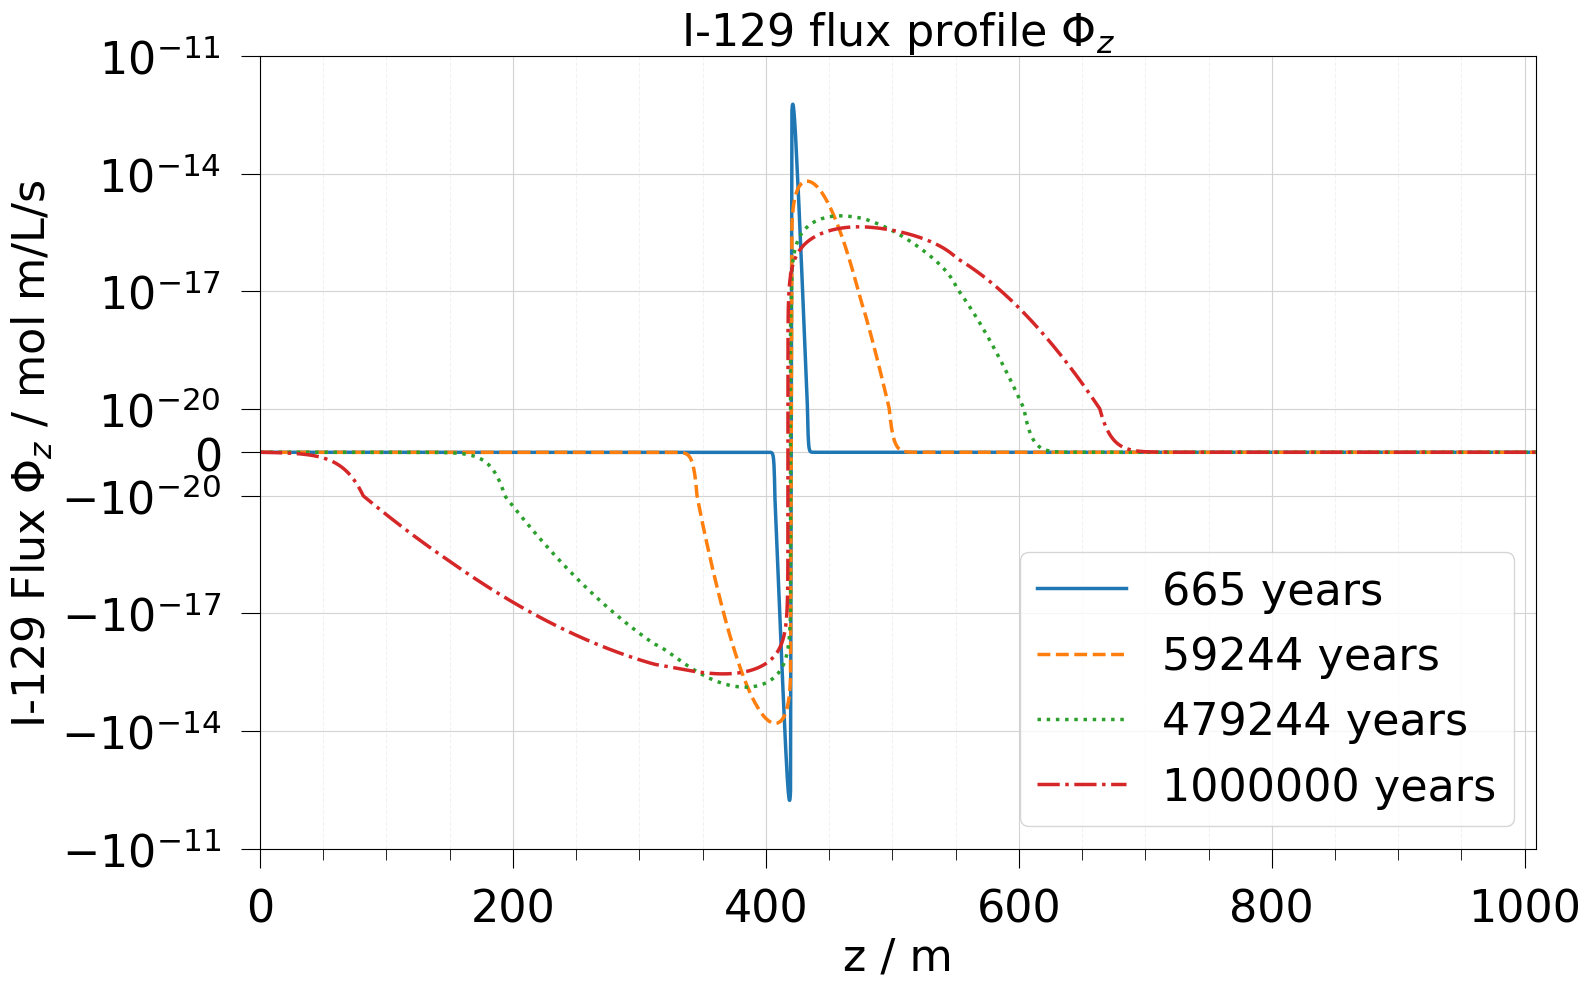

In [13]:
fig, ax = plt.subplots(figsize=(16, 10))

for mesh, label, style in zip(meshes, labels, style_cycler, strict=True):
    ot.plot.line(
        mesh,
        "z",
        I129Flux["z"],
        label=label,
        ax=ax,
        color=style["color"],
        linestyle=style["linestyle"],
        loc="lower right",
    )

fig.axes[0].set_yscale(
    "symlog", linthresh=10**-20
)  # By this, the y-axis is logarithmitic outside of [-1e-20,1e-20], and linear otherwise, however, some artifacts
# of double-plotting are there
fig.axes[0].set_ylim(-1e-11, 1e-11)
fig.axes[0].set_xlim(z_points.min(), z_points.max())
fig.axes[0].set_title(r"I-129 flux profile $\Phi_z$")

# Fix fontsizes
ot.plot.utils.update_font_sizes(fig.axes[0])
fig.tight_layout()

## Writing some example output

In some situations, it maybe helpful to dump the data into a `.csv` file. Here is an example to dump $t=10^6\,$yrs model into a `.csv` file.

In [14]:
mesh = ms.mesh(0)
x_points = mesh.points[:, 0]
y_points = mesh.points[:, 1]
z_points = mesh.points[:, 2]
pressure = ms.values("pressure")[0]
c_I129 = ms.values("[I-129]")[0]
f_I129_z = ms.values("[I-129]Flux")[0][:, 2]

save_string = "output_dump.txt"

all_NumInfo_to_write_concat = np.vstack(
    [x_points, y_points, z_points, pressure, c_I129, f_I129_z]
).T

with Path.open(save_string, mode="w") as f:
    header = (
        " x [m]"
        " y [m]"
        " z [m]"
        " pressure [Pa]"
        " [I-129] [mol/L] "
        "[I-129]Flux [mol m /L /s]"
        " \n"
    )
    f.write(header)
    np.savetxt(f, all_NumInfo_to_write_concat, fmt="%s")
f.close()

## Manipulating OGS-input-files and running OGS from Python

One of the main advantages of controlling OGS through Python is the ability to automate variations in model parameters.

In this section, we will make small modifications to the existing parameters in the `.prj` file and execute the simulation entirely within python.

In [15]:
project_dir_modified = project_dir / "modified/"
project_file_modified = project_dir_modified / "Iodide129_main_altered.prj"

if not project_dir_modified.exists():
    project_dir_modified.mkdir(parents=True)

out_dir_modified = project_dir_modified / "_out"
if not out_dir_modified.exists():
    out_dir_modified.mkdir(parents=True)

# Copy the original project file for parameter variation
ot.Project(project_file).write_input(project_file_modified)

In the current model, the parameters that can be varied are `retardation_factor`, `pore_diffusion`, and `porosity`.
In some cases, one might also modify the geometry, which involves changing the media IDs in the input `.vtu` files rather than in the `.prj` file.

In this example, we adjust the retardation factors of the layers from our original setup. This is for demonstration purposes only and does not reflect any physical justification.

In [16]:
property_to_vary = "retardation_factor"
retardation_factors_per_layer = np.arange(1.0, 11.0, 1.0)

no_of_parameter_variations = 1
no_of_layers = 10  # equal to number of material IDs, does not necessarily be layers, if the domain is 2D or 3D

for _ in range(no_of_parameter_variations):
    model = ot.Project(
        input_file=project_file_modified, output_file=project_file_modified
    )
    for j in range(no_of_layers):
        model.replace_text(
            retardation_factors_per_layer[j],
            xpath="./media/medium/phases/phase/components/component/properties/property[name='retardation_factor']/value",
            occurrence=j,
        )
        model.write_input()
        # please be aware that as such the "includes" in the ".prj"-file are not kept, but everything is written
        # directly in the ".prj"-file only, which should be fine for surrogate modelling though, and maybe even easier.

    model.run_model(args=f"-m {project_dir} -o {out_dir_modified}")

Project file written to output.
Simulation: modified/Iodide129_main_altered.prj
Status: finished successfully.
Execution took 3.3815011978149414 s


### Comparing the original model with the altered one

In [17]:
ms_altered = MeshSeries(out_dir_modified / "Iodide129_GIA.pvd").scale(time=("s", "yrs"))
ms_altered.mesh(0)

Mesh (0x7fd95331bb20)
  N Cells:    3811
  N Points:   3812
  X Bounds:   0.000e+00, 0.000e+00
  Y Bounds:   0.000e+00, 0.000e+00
  Z Bounds:   0.000e+00, 1.009e+03
  N Arrays:   4

In this example, we will now compare the I-129 spatial concentration profile.

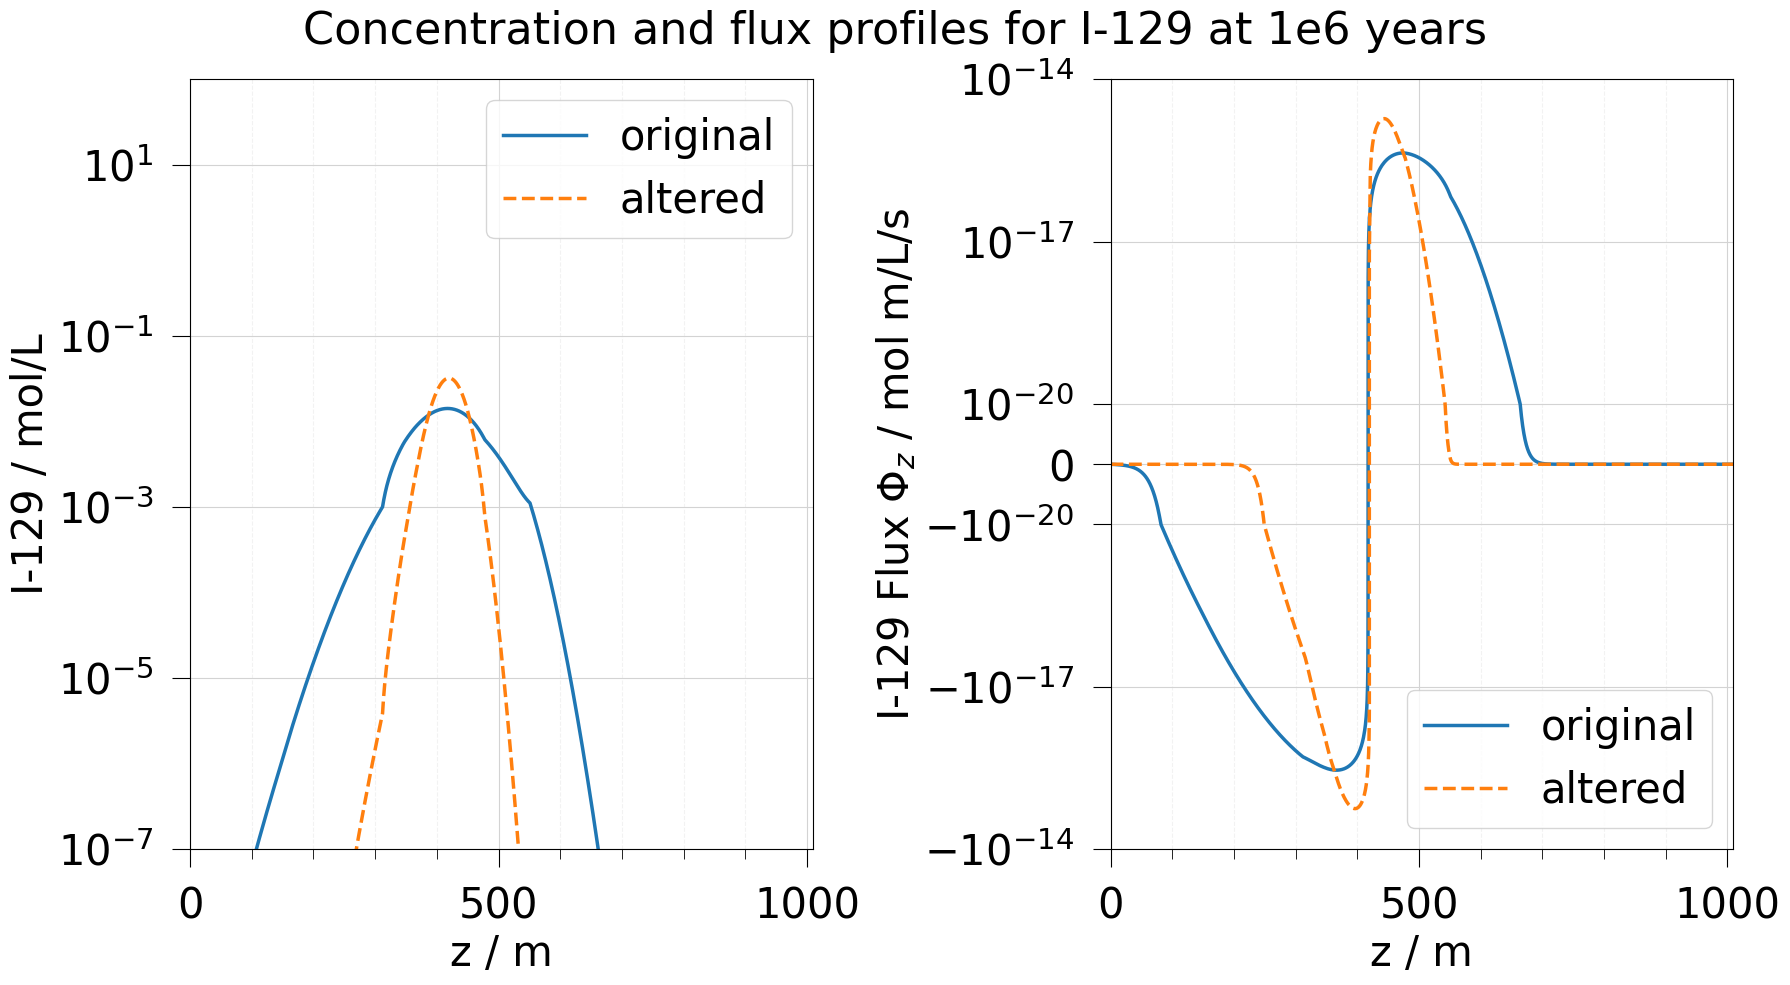

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 10))

ot.plot.line(ms_pvd[-1], "z", I129, label="original", ax=ax[0], color="C0")
ot.plot.line(
    ms_altered[-1],
    "z",
    I129,
    label="altered",
    ax=ax[0],
    color="C1",
    linestyle="--",
    fontsize=30,
)

ax[0].set_xlim(z_points.min(), z_points.max())
ax[0].set_yscale("log")
ax[0].set_ylim(1e-7, 1e2)

ot.plot.line(ms_pvd[-1], "z", I129Flux["z"], label="original", ax=ax[1], color="C0")
ot.plot.line(
    ms_altered[-1],
    "z",
    I129Flux["z"],
    label="altered",
    ax=ax[1],
    color="C1",
    linestyle="--",
    fontsize=30,
)
ax[1].set_ylim(-1e-14, 1e-14)
ax[1].set_yscale(
    "symlog", linthresh=10**-20
)  # By this, the y-axis is logarithmitic outside of [-1e-20,1e-20], and linear otherwise, however, some artifacts of double-plotting are there
ax[1].set_xlim(z_points.min(), z_points.max())

fig.suptitle("Concentration and flux profiles for I-129 at 1e6 years", fontsize=32)
fig.tight_layout()

At this stage, we have now completed the workflow: from setting up the environment, running OGS, reading and preparing results, to visualising data and testing parameter variations.

You can adapt the scripts to your own input files or extend them to include more advanced post-processing.

### Verifying simulation results

To ensure reproducibility, we compare the simulation output with a previously computed reference output.
The code below acts like a simple test by matching the outputs `I-129` concentration data at 1 million years.

In [19]:
ms_ref = MeshSeries(project_dir / "vtu/Iodide129_GIA_1e6yrs_reference_output.vtu")
np.testing.assert_allclose(ms_ref.point_data[I129], ms.point_data[I129])